In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [2]:
products = pd.read_csv('../data/olist_products_dataset.csv')
orders = pd.read_csv("../data/olist_orders_dataset.csv")
items = pd.read_csv("../data/olist_order_items_dataset.csv")
reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv")

# Gabung orders + items + reviews
merged = orders.merge(items, on='order_id')
merged = merged.merge(reviews[['order_id', 'review_score']], on='order_id')

# Ambil kolom yang relevan
df = merged[['customer_id', 'product_id', 'review_score']].dropna()
df = df.drop_duplicates()

df.head()

,customer_id,product_id,review_score
0,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4
1,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,4
2,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,5
3,f88197465ea7920adcdbec7375364d82,d0b61bfb1de832b15ba9d266ca96e5b0,5
4,8ab97904e6daea8866dbdbc4fb7aad2c,65266b2da20d04dbe00c5c2d3bb7859e,5


In [3]:
# Reader surprise butuh rating min dan max
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['customer_id', 'product_id', 'review_score']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

model = SVD()
model.fit(trainset)

# Evaluasi
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 1.3364


In [4]:
def get_top_n(predictions, n=5):
    from collections import defaultdict
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n=5)

# Lihat hasil rekomendasi user
sample_user = list(top_n.keys())[0]
print(f"Top 5 rekomendasi produk untuk user {sample_user}:\n", top_n[sample_user])

Top 5 rekomendasi produk untuk user 52efe753f546446eb1a37bb701656442:
 [('4fcb3d9a5f4871e8362dfedbdb02b064', 4.346011565636064)]


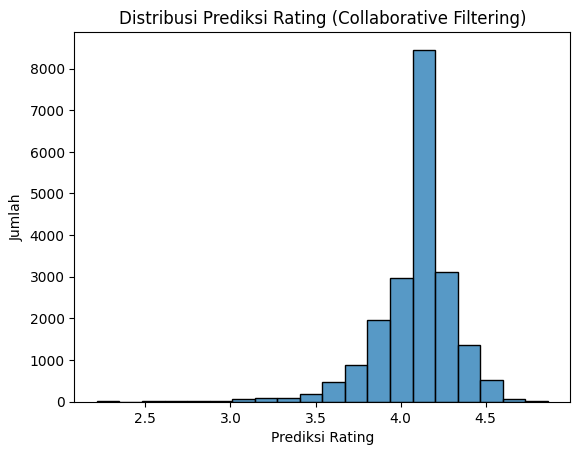

In [5]:
estimates = [pred.est for pred in predictions]
sns.histplot(estimates, bins=20)
plt.title("Distribusi Prediksi Rating (Collaborative Filtering)")
plt.xlabel("Prediksi Rating")
plt.ylabel("Jumlah")
plt.show()

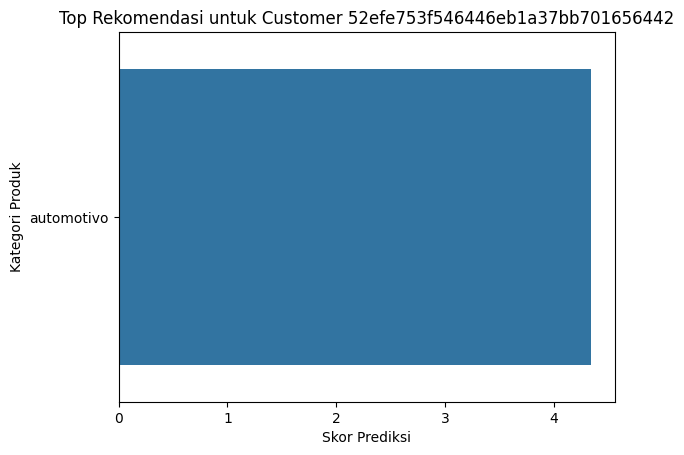

In [6]:
top_n = get_top_n(predictions, n=5)

user_id = list(top_n.keys())[0]
recommended_products = top_n[user_id]

# Gabungkan dengan data produk
rec_df = pd.DataFrame(recommended_products, columns=['product_id', 'estimated_score'])
rec_df = rec_df.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

sns.barplot(x='estimated_score', y='product_category_name', data=rec_df)
plt.title(f"Top Rekomendasi untuk Customer {user_id}")
plt.xlabel("Skor Prediksi")
plt.ylabel("Kategori Produk")
plt.show()


In [7]:
# Rekomendasi lebih dari satu

from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Load & train model
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['customer_id', 'product_id', 'review_score']], reader)
trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

# Cari produk yang belum diberi rating oleh user
def get_recommendations(model, trainset, user_id_raw, top_n=5):
    user_id_inner = trainset.to_inner_uid(user_id_raw)
    items_all = set(trainset.all_items())
    items_rated = set([j for (j, _) in trainset.ur[user_id_inner]])
    items_unrated = items_all - items_rated

    predictions = []
    for item_inner in items_unrated:
        item_raw = trainset.to_raw_iid(item_inner)
        pred = model.predict(user_id_raw, item_raw)
        predictions.append((item_raw, pred.est))

    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:top_n]

# Contoh pemakaian
user_id = "06b8999e2fba1a1fbc88172c00ba8bc7"
recommendations = get_recommendations(model, trainset, user_id, top_n=5)
for product_id, est_rating in recommendations:
    print(f"Produk {product_id} diprediksi rating {est_rating:.2f}")


Produk 574597aaf385996112490308e37399ce diprediksi rating 4.89
Produk b5b5a82ce5f1987b7e670f37629be51b diprediksi rating 4.89
Produk ffb97eb64c6fe1baada2410288c04457 diprediksi rating 4.88
Produk 17a019676883dce326999c11a46a14f0 diprediksi rating 4.88
Produk 3e4176d545618ed02f382a3057de32b4 diprediksi rating 4.87


# Modeling

In [8]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [12]:
import pickle
from src.recommender_cf import CollaborativeFilteringRecommender

cf_model = CollaborativeFilteringRecommender(df)
with open("../dashboard/cf_model.pkl", "wb") as f:
    pickle.dump(cf_model, f)

user_id = "06b8999e2fba1a1fbc88172c00ba8bc7"
recommendations = cf_model.get_recommendations(user_id, top_n=5)

# Contoh rekomendasi
for product_id, est_rating in recommendations:
    print(f"Produk {product_id} diprediksi rating {est_rating:.2f}")


Produk 3e4176d545618ed02f382a3057de32b4 diprediksi rating 4.90
Produk 73326828aa5efe1ba096223de496f596 diprediksi rating 4.82
Produk 1b8ee158f59c098470fad33f39660964 diprediksi rating 4.80
Produk a7d756e8f7c4b7e5b679e248a57d91ec diprediksi rating 4.79
Produk 36038dae78cc227e4d14b174f0f695d0 diprediksi rating 4.78


In [13]:
with open("../dashboard/cf_model.pkl", "rb") as f:
    model = pickle.load(f)

print(type(model))
print(dir(model))  # lihat semua method yang tersedia


<class 'src.recommender_cf.CollaborativeFilteringRecommender'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'data', 'get_recommendations', 'model', 'trainset']
